In [1]:
# This code evolves the Einstein-Klein Gordon system of equations in the 3+1 decomposition 
# using the reference metric approach in arXiv:1211.6632
# to avoid coordinate singularities in the right hand side evolution
# Spherical symmetry is assumed and the outer boundary condition is 
# extrapolation at zeroth order

# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
from myparams import *                         # go here to change the grid and other params
from source.rhsevolution import *              # go here to look at how the evolution works
from source.mytests import *                   # go here to change the test conditions
from source.diagnostics import *               # go here to change the  diagnostics

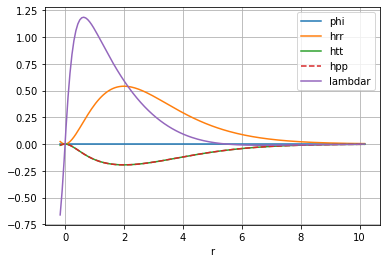

In [2]:
# This test sets up values such that R is known but phi = 0
initial_vars_values = get_test_vars_values_1()

#unpackage the vector for readability
u, v , phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = unpack_vars_vector(initial_vars_values)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, hpp, '--', label='hpp')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

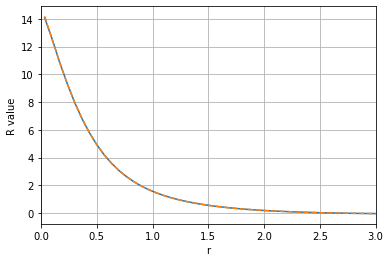

In [3]:
# calculate the diagnostics, the Ham constraint should just have 
# the term in bar_R so this tests the calculation of that quantity

# get the various derivs that we need to evolve things in vector form
# second derivatives
d2phidx2   = get_d2fdx2(phi)
d2hrrdx2   = get_d2fdx2(hrr)
d2httdx2   = get_d2fdx2(htt)
d2hppdx2   = get_d2fdx2(hpp)

# first derivatives
dphidx     = get_dfdx(phi)
dhrrdx     = get_dfdx(hrr)
dhttdx     = get_dfdx(htt)
dhppdx     = get_dfdx(hpp)
dlambdardx = get_dfdx(lambdar)

bar_R_test = np.zeros_like(phi)
chris_rrr  = np.zeros_like(phi)
chris_ttr  = np.zeros_like(phi)
chris_ppr  = np.zeros_like(phi)
Ricci_rr   = np.zeros_like(phi)
Ricci_tt   = np.zeros_like(phi)
Ricci_pp   = np.zeros_like(phi)

# now iterate over the grid (vector) and calculate the diagnostic values
for ix in range(num_ghosts, N-num_ghosts) :

    r_here = r[ix]

    # Assign BSSN vars to local tensors
    h = np.zeros_like(rank_2_spatial_tensor)
    h[i_r][i_r] = hrr[ix]
    h[i_t][i_t] = htt[ix]
    h[i_p][i_p] = hpp[ix]
    em4phi = np.exp(-4.0*phi[ix])

    dhdr = np.zeros_like(rank_2_spatial_tensor)
    dhdr[i_r][i_r] = dhrrdx[ix]
    dhdr[i_t][i_t] = dhttdx[ix]
    dhdr[i_p][i_p] = dhppdx[ix]

    d2hdr2 = np.zeros_like(rank_2_spatial_tensor)
    d2hdr2[i_r][i_r] = d2hrrdx2[ix]
    d2hdr2[i_t][i_t] = d2httdx2[ix]
    d2hdr2[i_p][i_p] = d2hppdx2[ix]
    
    # Calculate some useful quantities
    ########################################################

    # \hat \Gamma^i_jk
    flat_chris = get_flat_spherical_chris(r_here)

    # (unscaled) \bar\gamma_ij and \bar\gamma^ij
    bar_gamma_LL = get_metric(r_here, h)
    bar_gamma_UU = get_inverse_metric(r_here, h)
    
    # The connections Delta^i, Delta^i_jk and Delta_ijk
    Delta_U, Delta_ULL, Delta_LLL  = get_connection(r_here, bar_gamma_UU, bar_gamma_LL, h, dhdr)
    
    conformal_chris = get_conformal_chris(Delta_ULL, r_here)
    
    #chris_rrr[ix] = Delta_ULL[i_r][i_r][i_r] + flat_chris[i_r][i_r][i_r]
    #chris_ttr[ix] = Delta_ULL[i_t][i_t][i_r] + flat_chris[i_t][i_t][i_r]
    #chris_ppr[ix] = Delta_ULL[i_p][i_p][i_r] + flat_chris[i_p][i_p][i_r]   

    chris_rrr[ix] = conformal_chris[i_r][i_r][i_r]
    chris_ttr[ix] = conformal_chris[i_t][i_t][i_r]
    chris_ppr[ix] = conformal_chris[i_p][i_p][i_r]  

    epowr = np.exp(r_here)
    x = r_here
    Ricci_analytic = ( 0.5 * (epowr + x*x)**-4.0
                  * ( 8.0 * epowr * x**6.0 + 2.0 * x**8.0 
                     - epowr**2.0 * x**4.0 * (-12.0 + x*x)
                     + epowr**3.0 * x*x * (14.0 - 8.0*x + x*x)))
    
    bar_Rij = get_ricci_tensor(r_here, h, dhdr, d2hdr2, lambdar[ix], dlambdardx[ix], 
                                       Delta_U, Delta_ULL, Delta_LLL, bar_gamma_UU, bar_gamma_LL)
        
    bar_R_test[ix]   = get_trace(bar_Rij, bar_gamma_UU)
    
    Ricci_rr[ix] = bar_Rij[i_r][i_r]
    Ricci_tt[ix] = bar_Rij[i_t][i_t]
    Ricci_pp[ix] = bar_Rij[i_p][i_p]

# Plot the Ricci scalar
bar_R_plot = bar_R_test[num_ghosts:(N-num_ghosts)]
r_diagnostics = r[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, bar_R_plot)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
tmp = (1.0 + x*x/epowr)**(0.5)
R_analytic = (1.0 / 8.0 / (x*x) * (epowr + x*x)**(-3.0) * 
              (16.0 * (x**6.0) * tmp
               - epowr * (x**4.0) * (-20.0  + 12.0*x + 7.0*x*x - 48.0*tmp)
               + 16.0 * epowr**3.0 * (-1.0 + tmp)
               + 8.0 * epowr**2.0 * x*x * (8.0 - 9.0*x + x*x + 6 * tmp)))

plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('R value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

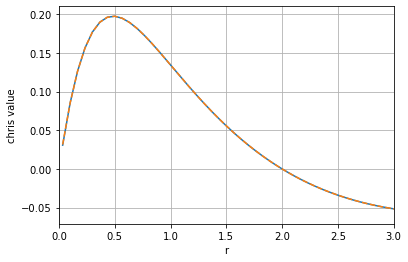

In [4]:
# Plot christoffels
chris_rrr_d = chris_rrr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_rrr_d)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_rrr_analytic = -(0.5 * x * (x-2.0) / (epowr + x*x))
plt.plot(x, chris_rrr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

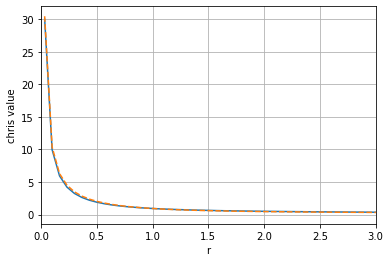

In [5]:
# Plot christoffels
chris_ttr_d = chris_ttr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_ttr_d)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_ttr_analytic = (( 4.0 * epowr + 2.0*x + x**3.0 ) / (4.0 * x * epowr + 4.0 * x**3.0))
plt.plot(x, chris_ttr_analytic, '--')
#plt.plot(x, 1.0/x, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

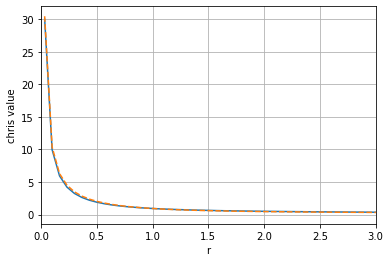

In [6]:
# Plot christoffels
chris_ppr_d = chris_ppr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_ppr_d)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_ppr_analytic = chris_ttr_analytic
plt.plot(x, chris_ppr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

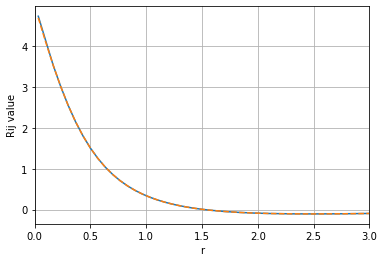

In [7]:
# Plot comps of Ricci - R_rr
Ricci_ij_d = Ricci_rr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
Ricci_analytic = ( (1.0/8.0) * (epowr + x*x)**-2.0 
              * ( x*x * (12 - 4.0*x - 3.0*x*x) 
                  + 4.0 * epowr * (10.0 - 8.0*x + x*x)))
plt.plot(x, Ricci_analytic, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

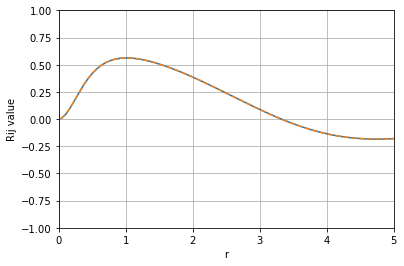

In [8]:
# Plot comps of Ricci - R_tt
Ricci_ij_d = Ricci_tt[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
tmp = (1.0 + x*x/epowr)**(0.5)
Ricci_analytic_tt = ( 0.25 * epowr**2.0 * tmp * ((epowr + x*x)**(-4.0))
                  * ( -4.0 * epowr**2.0 
                     + epowr * x**2.0 * (6.0 -10.0*x +x*x) 
                     - x**4.0 * (-2.0 + 2.0*x + x*x))) + 1.0
plt.plot(x, Ricci_analytic_tt, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

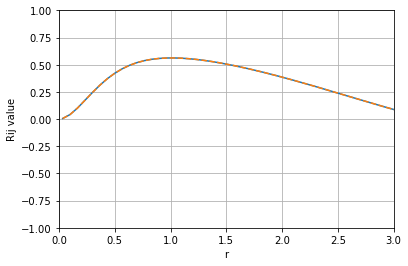

In [9]:
# Plot comps of Ricci - R_pp
Ricci_ij_d = Ricci_pp[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
Ricci_analytic_pp = Ricci_analytic_tt
plt.plot(x, Ricci_analytic_pp, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,3)
plt.ylim(-1,1)
plt.grid()

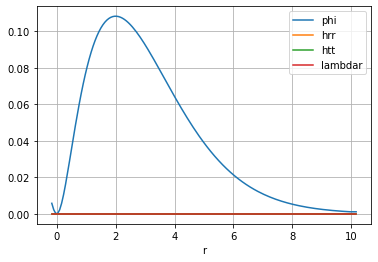

In [10]:
# This test sets up values such that R is known but bar_R = 0
initial_vars_values = get_test_vars_values_2()

#unpackage the vector for readability
u, v , phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = unpack_vars_vector(initial_vars_values)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [ ]:
# calculate the diagnostics, the Ham constraint should just have 
# the terms in dphi, so this tests those, and Delta_U
# get the various derivs that we need to evolve things in vector form
# second derivatives
d2phidx2   = get_d2fdx2(phi)
d2hrrdx2   = get_d2fdx2(hrr)
d2httdx2   = get_d2fdx2(htt)
d2hppdx2   = get_d2fdx2(hpp)

# first derivatives
dphidx     = get_dfdx(phi)
dhrrdx     = get_dfdx(hrr)
dhttdx     = get_dfdx(htt)
dhppdx     = get_dfdx(hpp)
dlambdardx = get_dfdx(lambdar)

bar_R_test = np.zeros_like(phi)
Ham_test = np.zeros_like(phi)

# now iterate over the grid (vector) and calculate the diagnostic values
for ix in range(num_ghosts, N-num_ghosts) :

    r_here = r[ix]

    # Assign BSSN vars to local tensors
    h = np.zeros_like(rank_2_spatial_tensor)
    h[i_r][i_r] = hrr[ix]
    h[i_t][i_t] = htt[ix]
    h[i_p][i_p] = hpp[ix]
    em4phi = np.exp(-4.0*phi[ix])

    dhdr = np.zeros_like(rank_2_spatial_tensor)
    dhdr[i_r][i_r] = dhrrdx[ix]
    dhdr[i_t][i_t] = dhttdx[ix]
    dhdr[i_p][i_p] = dhppdx[ix]

    d2hdr2 = np.zeros_like(rank_2_spatial_tensor)
    d2hdr2[i_r][i_r] = d2hrrdx2[ix]
    d2hdr2[i_t][i_t] = d2httdx2[ix]
    d2hdr2[i_p][i_p] = d2hppdx2[ix]

    a = np.zeros_like(rank_2_spatial_tensor)
    a[i_r][i_r] = arr[ix]
    a[i_t][i_t] = att[ix]
    a[i_p][i_p] = app[ix]
    
    # Calculate some useful quantities
    ########################################################

    # \hat \Gamma^i_jk
    flat_chris = get_flat_spherical_chris(r_here)

    # rescaled \bar\gamma_ij
    r_gamma_LL = get_rescaled_metric(h)
    r_gamma_UU = get_rescaled_inverse_metric(h)

    # (unscaled) \bar\gamma_ij and \bar\gamma^ij
    bar_gamma_LL = get_metric(r_here, h)
    bar_gamma_UU = get_inverse_metric(r_here, h)
    
    # The connections Delta^i, Delta^i_jk and Delta_ijk
    Delta_U, Delta_ULL, Delta_LLL  = get_connection(r_here, bar_gamma_UU, bar_gamma_LL, h, dhdr)
    
    conformal_chris = get_conformal_chris(Delta_ULL, r_here)
    
    #chris_rrr[ix] = Delta_ULL[i_r][i_r][i_r] + flat_chris[i_r][i_r][i_r]
    #chris_ttr[ix] = Delta_ULL[i_t][i_t][i_r] + flat_chris[i_t][i_t][i_r]
    #chris_ppr[ix] = Delta_ULL[i_p][i_p][i_r] + flat_chris[i_p][i_p][i_r]   

    chris_rrr[ix] = conformal_chris[i_r][i_r][i_r]
    chris_ttr[ix] = conformal_chris[i_t][i_t][i_r]
    chris_ppr[ix] = conformal_chris[i_p][i_p][i_r]     
    
    bar_Rij = get_ricci_tensor(r_here, h, dhdr, d2hdr2, lambdar[ix], dlambdardx[ix], 
                                       Delta_U, Delta_ULL, Delta_LLL, bar_gamma_UU, bar_gamma_LL)
    bar_R_test[ix]   = get_trace(bar_Rij, bar_gamma_UU)
    
    # Get the Ham constraint eqn (13) of Baumgarte https://arxiv.org/abs/1211.6632
    Ham_test[ix] = em4phi * ( bar_R_test[ix] #should be zero
                           - 8.0 * bar_gamma_UU[i_r][i_r] * (dphidx[ix] * dphidx[ix]
                                                                        + d2phidx2[ix])
                           # These terms come from \bar\Gamma^r d_r \phi from the \bar D^2 \phi term
                           + 8.0 * bar_gamma_UU[i_t][i_t] * dphidx[ix] * flat_chris[i_r][i_t][i_t]
                           + 8.0 * bar_gamma_UU[i_p][i_p] * dphidx[ix] * flat_chris[i_r][i_p][i_p]
                           + 8.0 * Delta_U[i_r] * dphidx[ix]) #should be zero
    

# Plot the result
Ham_plot = Ham_test[num_ghosts:(N-num_ghosts)]
r_diagnostics = r[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ham_plot)

#analytic result for test 2
epowr = np.exp(r_diagnostics)
x = r_diagnostics
R_analytic = - (0.5 * epowr * (epowr + x*x)**-3.0 
              * ( x*x * (12.0 - 12.0*x + x*x) 
                 + 4.0 * epowr * (6.0 - 6.0* x + x*x)))


plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('Ham value')
plt.xlim(0,3)
#plt.ylim(-12,1)
plt.grid()